## HW3 - Moody Billah

Loading the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.naive_bayes import MultinomialNB 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

### Data

Loading and cleaning the dataset by re-using code from HW2_EDA.

In [2]:
data_path = 'https://raw.githubusercontent.com/ulabox/datasets/master/data/ulabox_orders_with_categories_partials_2017.csv'
ulabox_data = pd.read_csv(data_path)

ulabox_data.drop(columns=['customer', 'order'], inplace=True)

day_names = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
ulabox_data['weekday'] = ulabox_data['weekday'].replace(day_names)

day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ulabox_data['weekday'] = ulabox_data['weekday'].astype('category').cat.reorder_categories(day_order)

ulabox_data['hour'] = ulabox_data['hour'].astype(str).str.pad(2, fillchar='0') + 'h'

ulabox_data.head()

,total_items,discount%,weekday,hour,Food%,Fresh%,Drinks%,Home%,Beauty%,Health%,Baby%,Pets%
0,45,23.03,Thu,13h,9.46,87.06,3.48,0.00,0.00,0.00,0.0,0.0
1,38,1.22,Fri,13h,15.87,75.80,6.22,2.12,0.00,0.00,0.0,0.0
2,51,18.08,Thu,13h,16.88,56.75,3.37,16.48,6.53,0.00,0.0,0.0
3,57,16.51,Mon,12h,28.81,35.99,11.78,4.62,2.87,15.92,0.0,0.0
4,53,18.31,Tue,11h,24.13,60.38,7.78,7.72,0.00,0.00,0.0,0.0


### Feature Engineering

Converting the response variables to probalities where the value is between 0 and 1.

In [3]:
ulabox_data.columns = ulabox_data.columns.astype(str).str.replace('%', '')
ulabox_data.loc[:,'Food':'Pets'] = ulabox_data.loc[:,'Food':'Pets']/100
ulabox_data.head()

,total_items,discount,weekday,hour,Food,Fresh,Drinks,Home,Beauty,Health,Baby,Pets
0,45,23.03,Thu,13h,0.0946,0.8706,0.0348,0.0000,0.0000,0.0000,0.0,0.0
1,38,1.22,Fri,13h,0.1587,0.7580,0.0622,0.0212,0.0000,0.0000,0.0,0.0
2,51,18.08,Thu,13h,0.1688,0.5675,0.0337,0.1648,0.0653,0.0000,0.0,0.0
3,57,16.51,Mon,12h,0.2881,0.3599,0.1178,0.0462,0.0287,0.1592,0.0,0.0
4,53,18.31,Tue,11h,0.2413,0.6038,0.0778,0.0772,0.0000,0.0000,0.0,0.0


Min-max normalization of continuous explanatory variables so that values are between 0 and 1.

In [4]:
ulabox_data[['total_items', 'discount']] = MinMaxScaler().fit_transform(ulabox_data[['total_items', 'discount']])
ulabox_data.head()

,total_items,discount,weekday,hour,Food,Fresh,Drinks,Home,Beauty,Health,Baby,Pets
0,0.148148,0.533939,Thu,13h,0.0946,0.8706,0.0348,0.0000,0.0000,0.0000,0.0,0.0
1,0.124579,0.401877,Fri,13h,0.1587,0.7580,0.0622,0.0212,0.0000,0.0000,0.0,0.0
2,0.168350,0.503966,Thu,13h,0.1688,0.5675,0.0337,0.1648,0.0653,0.0000,0.0,0.0
3,0.188552,0.494460,Mon,12h,0.2881,0.3599,0.1178,0.0462,0.0287,0.1592,0.0,0.0
4,0.175084,0.505359,Tue,11h,0.2413,0.6038,0.0778,0.0772,0.0000,0.0000,0.0,0.0


One hot encoding of categorical explanatory variables. The base for 'weekday' is 'Mon' and the base for 'hour' is '00h'.

In [5]:
ulabox_data = pd.get_dummies(ulabox_data, drop_first=True)
ulabox_data.columns

Index(['total_items', 'discount', 'Food', 'Fresh', 'Drinks', 'Home', 'Beauty',
       'Health', 'Baby', 'Pets', 'weekday_Tue', 'weekday_Wed', 'weekday_Thu',
       'weekday_Fri', 'weekday_Sat', 'weekday_Sun', 'hour_01h', 'hour_02h',
       'hour_03h', 'hour_04h', 'hour_05h', 'hour_06h', 'hour_07h', 'hour_08h',
       'hour_09h', 'hour_10h', 'hour_11h', 'hour_12h', 'hour_13h', 'hour_14h',
       'hour_15h', 'hour_16h', 'hour_17h', 'hour_18h', 'hour_19h', 'hour_20h',
       'hour_21h', 'hour_22h', 'hour_23h'],
      dtype='object')

### Modeling

Splitting the data into training and test sets, then separating the response and explanatory variables.

In [6]:
ulabox_train, ulabox_test = train_test_split(ulabox_data, test_size=0.2, random_state=100)
ulabox_train.reset_index(drop=True, inplace=True)
ulabox_test.reset_index(drop=True, inplace=True)

response_cols = ulabox_data.loc[:,'Food':'Pets'].columns
response_train = ulabox_train[response_cols]
response_test = ulabox_test[response_cols]

response_train_max = response_train.idxmax(axis='columns')
response_test_max = response_test.idxmax(axis='columns')

explanatory_train = ulabox_train.drop(columns=response_cols)
explanatory_test = ulabox_test.drop(columns=response_cols)

Fitting the first model which is a Multinomial Naive Bayes classifier with priors adjusted according to the data.

In [7]:
model1 = MultinomialNB()
model1.fit(explanatory_train, response_train_max)

MultinomialNB()

The confusion matrix compares the predicted max spend category with the true max spend category. It shows that this is not a good model because most of the points were classified into the Fresh category, so it could not accurately predict the other categories.

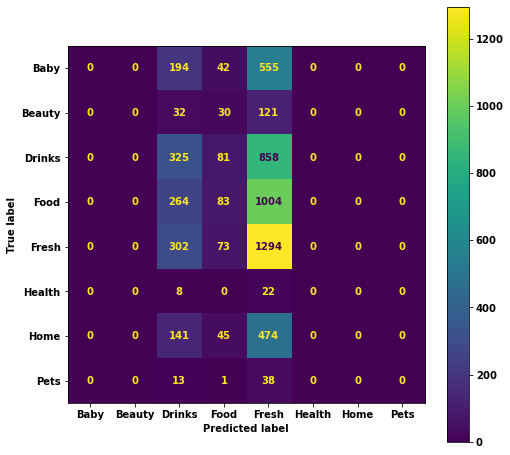

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model1, explanatory_test, response_test_max, ax=ax)
plt.show()

The predicted probabilities for each category, which represents the predicted share of spending.

In [9]:
response_pred1 = pd.DataFrame(model1.predict_proba(explanatory_test))
response_pred1.columns = sorted(response_cols)
response_pred1.head()

,Baby,Beauty,Drinks,Food,Fresh,Health,Home,Pets
0,0.090366,0.019817,0.248627,0.221015,0.304962,0.007867,0.102646,0.004699
1,0.131110,0.011975,0.267890,0.214284,0.240783,0.005960,0.114763,0.013234
2,0.085705,0.039234,0.261286,0.228633,0.282775,0.006396,0.091530,0.004443
3,0.096537,0.021962,0.280920,0.237241,0.230073,0.005878,0.119754,0.007636
4,0.110756,0.031448,0.216146,0.245970,0.265197,0.003987,0.118064,0.008433


The mean absolute error between the predicted and true share of each category. The error values are quite high because the model misclassified many points.

In [10]:
abs(response_test - response_pred1).mean()

Baby      0.178470
Beauty    0.066184
Drinks    0.165970
Food      0.161041
Fresh     0.212353
Health    0.015508
Home      0.124686
Pets      0.017513
dtype: float64

Setting the fixed priors as the mean of each response category.

In [11]:
priors = list(response_train.mean().sort_index())
priors[0] = priors[0] + (1 - sum(priors))

Fitting the second model which is a Multinomial Naive Bayes classifier with fixed priors.

In [12]:
model2 = MultinomialNB(class_prior=priors)
model2.fit(explanatory_train, response_train_max)

MultinomialNB(class_prior=[0.11302656666666666, 0.059004383333333334,
                           0.23503395833333335, 0.234795625,
                           0.20092989166666667, 0.011331308333333335,
                           0.13577545, 0.010102816666666667])

The confusion matrix compares the predicted max spend category with the true max spend category. It shows that this is a more balanced model because most of the points were classified into 3 categories rather than 1. However, this model still lacks prediction accuracy.

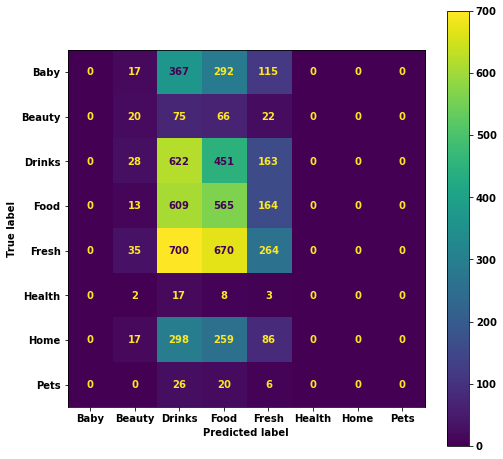

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model2, explanatory_test, response_test_max, ax=ax)
plt.show()

The predicted probabilities for each category, which represents the predicted share of spending.

In [14]:
response_pred2 = pd.DataFrame(model2.predict_proba(explanatory_test))
response_pred2.columns = sorted(response_cols)
response_pred2.head()

,Baby,Beauty,Drinks,Food,Fresh,Health,Home,Pets
0,0.075984,0.036614,0.263631,0.237202,0.234616,0.017169,0.127626,0.007156
1,0.109423,0.021961,0.281943,0.228267,0.183863,0.012910,0.141629,0.020003
2,0.070717,0.071131,0.271873,0.240789,0.213478,0.013697,0.111676,0.006639
3,0.079225,0.039603,0.290724,0.248505,0.172753,0.012519,0.145323,0.011348
4,0.091593,0.057144,0.225410,0.259631,0.200659,0.008558,0.144374,0.012630


The mean absolute error between the predicted and true share of each category. The error values are still quite high because the model could not accurately classify most points.

In [15]:
abs(response_test - response_pred2).mean()

Baby      0.165672
Beauty    0.076177
Drinks    0.168314
Food      0.162780
Fresh     0.196593
Health    0.020410
Home      0.131239
Pets      0.020445
dtype: float64

### Answering Business Question

When a new order is initiated, the business will use the predicted probabilities for each response category to represent the predicted share of customer spending. The share of product recommendations per category will be based on those predictions. 

Since the current model is not very accurate, implementing the predictions may not have a significant impact on increasing customer spending. This is largely due to limitations in the data provided. However, this model is a good starting point and better models can be built afterwards if more relevant data is collected.